# Package

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
%load_ext autoreload
%autoreload 2

# Set up environment

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return "%.2f" % size, power_labels[n] + 'bytes'

torch.cuda.get_device_name(), format_bytes(torch.cuda.get_device_properties(device).total_memory)

('GeForce GTX 1080 Ti', ('10.92', 'gigabytes'))

# Load data

In [4]:
from preprocessing.load_dataset import raw_to_dict

In [5]:
trainset, valset = raw_to_dict(data_mode = "small")
# trainset, valset = raw_to_dict()

100%|██████████| 1000/1000 [00:00<00:00, 1383802.05it/s]


>> Loading msimut at /home/kientiet/Documents/My Project/python/ucla-cs168/data/msimut_small
>> Total running 1000

>> Loading msimut at /home/kientiet/Documents/My Project/python/ucla-cs168/data/mss_small
>> Total running 1000

>> Splitting the dataset

>> From dictionary to data instance

>> Done!


In [6]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 4)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, num_workers = 4)
len(trainloader), len(valloader)

(103, 67)

torch.Size([16, 3, 224, 224]) torch.Size([16])


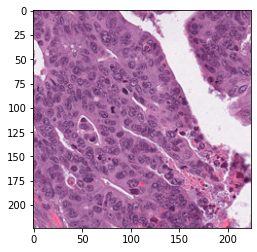

In [7]:
images, labels = next(iter(trainloader))

print(images.shape, labels.shape)
def imshow(img):
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # plt.show()

imshow(images[0])

# BagNet Orginial 

In [18]:
from trainer.bagnetorg_trainer import BagNetOrgTrainer

In [9]:
bagnetorg_trainer = BagNetOrgTrainer(trainloader, valloader, num_cycle = 5)
max_epochs = bagnetorg_trainer.get_max_epochs()

In [19]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", "bagnetorg")
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = 5,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

checkpoint_path

'/home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg'

In [20]:
tb_logger = loggers.TensorBoardLogger('logs/', name = "bagnetorg_bagnet9")
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                     nb_sanity_val_steps=0, 
                     max_epochs = max_epochs, 
                     gpus = -1, 
                    logger = tb_logger
                    )

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


## Learning rate finder

In [21]:
lr_finder = trainer.lr_find(bagnetorg_trainer)

INFO:lightning:
    | Name                        | Type             | Params
-------------------------------------------------------------
0   | criterion                   | CrossEntropyLoss | 0     
1   | model                       | BagNet           | 15 M  
2   | model.conv1                 | Conv2d           | 192   
3   | model.conv2                 | Conv2d           | 36 K  
4   | model.bn1                   | BatchNorm2d      | 128   
5   | model.relu                  | ReLU             | 0     
6   | model.layer1                | Sequential       | 150 K 
7   | model.layer1.0              | Bottleneck       | 75 K  
8   | model.layer1.0.conv1        | Conv2d           | 4 K   
9   | model.layer1.0.bn1          | BatchNorm2d      | 128   
10  | model.layer1.0.conv2        | Conv2d           | 36 K  
11  | model.layer1.0.bn2          | BatchNorm2d      | 128   
12  | model.layer1.0.conv3        | Conv2d           | 16 K  
13  | model.layer1.0.bn3          | BatchNorm2d      |

Adam


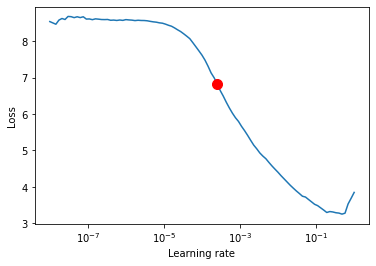

In [23]:
fig = lr_finder.plot(suggest = True)

In [24]:
bagnetorg_trainer.base_lr = 1e-3
bagnetorg_trainer.max_lr = 8e-2
bagnetorg_trainer.configure_optimizers()

Adam (
Parameter Group 0
    amsgrad: False
    base_momentum: 0.85
    betas: (0.95, 0.999)
    eps: 1e-08
    initial_lr: 0.0032
    lr: 0.0031999999999999945
    max_lr: 0.08
    max_momentum: 0.95
    min_lr: 3.2e-07
    weight_decay: 0
)

## Train the model

In [25]:
trainer.fit(bagnetorg_trainer)

INFO:lightning:
    | Name                        | Type             | Params
-------------------------------------------------------------
0   | criterion                   | CrossEntropyLoss | 0     
1   | model                       | BagNet           | 15 M  
2   | model.conv1                 | Conv2d           | 192   
3   | model.conv2                 | Conv2d           | 36 K  
4   | model.bn1                   | BatchNorm2d      | 128   
5   | model.relu                  | ReLU             | 0     
6   | model.layer1                | Sequential       | 150 K 
7   | model.layer1.0              | Bottleneck       | 75 K  
8   | model.layer1.0.conv1        | Conv2d           | 4 K   
9   | model.layer1.0.bn1          | BatchNorm2d      | 128   
10  | model.layer1.0.conv2        | Conv2d           | 36 K  
11  | model.layer1.0.bn2          | BatchNorm2d      | 128   
12  | model.layer1.0.conv3        | Conv2d           | 16 K  
13  | model.layer1.0.bn3          | BatchNorm2d      |

INFO:lightning:
Epoch 00001: val_loss reached 712284.00000 (best 712284.00000), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=1.ckpt as top 5


INFO:lightning:
Epoch 00002: val_loss reached 0.70508 (best 0.70508), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=2.ckpt as top 5


INFO:lightning:
Epoch 00003: val_loss reached 0.70040 (best 0.70040), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=3.ckpt as top 5


/home/kientiet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:lightning:
Epoch 00004: val_loss reached 0.74787 (best 0.70040), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=4.ckpt as top 5


INFO:lightning:
Epoch 00005: val_loss reached 0.70305 (best 0.70040), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=5.ckpt as top 5


INFO:lightning:
Epoch 00006: val_loss reached 0.73080 (best 0.70040), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=6.ckpt as top 5


INFO:lightning:
Epoch 00007: val_loss reached 0.70435 (best 0.70040), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=7.ckpt as top 5


INFO:lightning:
Epoch 00008: val_loss reached 0.70123 (best 0.70040), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=8.ckpt as top 5


INFO:lightning:
Epoch 00009: val_loss reached 0.70172 (best 0.70040), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=9.ckpt as top 5


INFO:lightning:
Epoch 00010: val_loss reached 0.69378 (best 0.69378), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=10.ckpt as top 5


INFO:lightning:
Epoch 00011: val_loss reached 0.69857 (best 0.69378), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=11.ckpt as top 5


INFO:lightning:
Epoch 00012: val_loss  was not in top 5


INFO:lightning:
Epoch 00013: val_loss reached 0.69448 (best 0.69378), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=13.ckpt as top 5


INFO:lightning:
Epoch 00014: val_loss reached 0.69556 (best 0.69378), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=14.ckpt as top 5


INFO:lightning:
Epoch 00015: val_loss  was not in top 5


INFO:lightning:
Epoch 00016: val_loss  was not in top 5


INFO:lightning:
Epoch 00017: val_loss  was not in top 5


INFO:lightning:
Epoch 00018: val_loss reached 0.69856 (best 0.69378), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=18.ckpt as top 5


INFO:lightning:
Epoch 00019: val_loss  was not in top 5


1

# BagNet Model

In [8]:
from trainer.bagnet_trainer import BagNetTrainer

In [9]:
bagnet_trainer = BagNetTrainer(trainloader, valloader, num_cycle = 5)
max_epochs = bagnet_trainer.get_max_epochs()

In [16]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", "bagnet")
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = 5,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

checkpoint_path

'/home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnet'

In [17]:
tb_logger = loggers.TensorBoardLogger('logs/', name = "bagnet")
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                     nb_sanity_val_steps=0, 
                     max_epochs = max_epochs, 
                     gpus = -1, 
                     logger = tb_logger)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


# Learning rate finder

In [12]:
lr_finder = trainer.lr_find(bagnet_trainer)

INFO:lightning:
    | Name                        | Type               | Params
---------------------------------------------------------------
0   | criterion                   | CrossEntropyLoss   | 0     
1   | model                       | BagNetArchitecture | 13 M  
2   | model.stem_heads            | Sequential         | 37 K  
3   | model.stem_heads.0          | Conv2d             | 192   
4   | model.stem_heads.1          | Conv2d             | 36 K  
5   | model.stem_heads.2          | BatchNorm2d        | 128   
6   | model.stem_heads.3          | ReLU               | 0     
7   | model.layer1                | Sequential         | 150 K 
8   | model.layer1.0              | Bottleneck         | 75 K  
9   | model.layer1.0.conv1        | Conv2d             | 4 K   
10  | model.layer1.0.bn1          | BatchNorm2d        | 128   
11  | model.layer1.0.conv2        | Conv2d             | 36 K  
12  | model.layer1.0.bn2          | BatchNorm2d        | 128   
13  | model.layer1.0.con

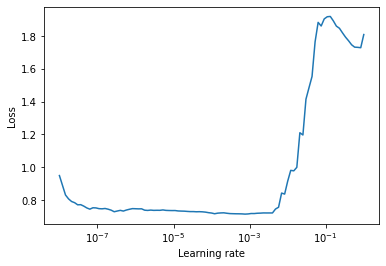

In [13]:
fig = lr_finder.plot(suggest = True)

In [15]:
bagnet_trainer.base_lr = 2e-3
bagnet_trainer.max_lr = 8e-2
bagnet_trainer.configure_optimizers()

SGD (
Parameter Group 0
    base_momentum: 0.85
    dampening: 0
    initial_lr: 0.0032
    lr: 0.0031999999999999945
    max_lr: 0.08
    max_momentum: 0.95
    min_lr: 3.2e-07
    momentum: 0.95
    nesterov: False
    weight_decay: 0
)

## Train the model

In [18]:
trainer.fit(bagnet_trainer)

INFO:lightning:
    | Name                        | Type               | Params
---------------------------------------------------------------
0   | criterion                   | CrossEntropyLoss   | 0     
1   | model                       | BagNetArchitecture | 13 M  
2   | model.stem_heads            | Sequential         | 37 K  
3   | model.stem_heads.0          | Conv2d             | 192   
4   | model.stem_heads.1          | Conv2d             | 36 K  
5   | model.stem_heads.2          | BatchNorm2d        | 128   
6   | model.stem_heads.3          | ReLU               | 0     
7   | model.layer1                | Sequential         | 150 K 
8   | model.layer1.0              | Bottleneck         | 75 K  
9   | model.layer1.0.conv1        | Conv2d             | 4 K   
10  | model.layer1.0.bn1          | BatchNorm2d        | 128   
11  | model.layer1.0.conv2        | Conv2d             | 36 K  
12  | model.layer1.0.bn2          | BatchNorm2d        | 128   
13  | model.layer1.0.con

INFO:lightning:
Epoch 00000: val_loss reached 3.31488 (best 3.31488), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_0.ckpt as top 5


INFO:lightning:
Epoch 00001: val_loss reached 0.71230 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_1.ckpt as top 5


/home/kientiet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:lightning:
Epoch 00002: val_loss reached 11.11442 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_2.ckpt as top 5


INFO:lightning:
Epoch 00003: val_loss reached 3.87876 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_3.ckpt as top 5


INFO:lightning:
Epoch 00004: val_loss reached 1.31419 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_4.ckpt as top 5


INFO:lightning:
Epoch 00005: val_loss reached 5.22943 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_5.ckpt as top 5


INFO:lightning:
Epoch 00006: val_loss reached 1.93126 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_6.ckpt as top 5


INFO:lightning:
Epoch 00007: val_loss reached 1.78376 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_7.ckpt as top 5


INFO:lightning:
Epoch 00008: val_loss reached 1.68511 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_8.ckpt as top 5


INFO:lightning:
Epoch 00009: val_loss reached 1.14922 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_9.ckpt as top 5


INFO:lightning:
Epoch 00010: val_loss reached 0.90562 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_10.ckpt as top 5


INFO:lightning:
Epoch 00011: val_loss reached 1.07020 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_11.ckpt as top 5


INFO:lightning:
Epoch 00012: val_loss reached 1.00995 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_12.ckpt as top 5


INFO:lightning:
Epoch 00013: val_loss reached 0.74607 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_13.ckpt as top 5


INFO:lightning:
Epoch 00014: val_loss reached 0.72725 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_14.ckpt as top 5


INFO:lightning:
Epoch 00015: val_loss reached 0.86829 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_15.ckpt as top 5


INFO:lightning:
Epoch 00016: val_loss reached 0.76531 (best 0.71230), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_16.ckpt as top 5


INFO:lightning:
Epoch 00017: val_loss  was not in top 5


INFO:lightning:
Epoch 00018: val_loss reached 0.70256 (best 0.70256), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_18.ckpt as top 5


INFO:lightning:
Epoch 00019: val_loss reached 0.68715 (best 0.68715), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/_ckpt_epoch_19.ckpt as top 5


1